In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from crypto_bot.utils import save_obj, load_obj
from crypto_bot.model.data import plot_df, plot_by_date, plot_by_idx

DATA_FOLDER = 'C:/Users/diego/crypto_bot/data'
WEIGHTS_PATH = 'C:/Users/diego/crypto_bot/data/models'

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load Data

In [2]:
valid_ds_name = '{}/data_loaders/valid_binary_dataset.ds'.format(DATA_FOLDER)

# Load
valid_dataset = load_obj(valid_ds_name)
valid_dataset.to(DEVICE)

# Load models

In [3]:
net = load_obj(WEIGHTS_PATH + '/net.pickle')
net.to(DEVICE)

ResNetTest(
  (block1): ResBlock(
    (conv1): Conv1d(5, 32, kernel_size=(8,), stride=(1,), padding=same)
    (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=same)
    (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=same)
    (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential(
      (0): Conv1d(5, 32, kernel_size=(1,), stride=(1,), bias=False)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (do1): Dropout(p=0.25, inplace=False)
  (block2): ResBlock(
    (conv1): Conv1d(32, 32, kernel_size=(8,), stride=(1,), padding=same)
    (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(32, 32, kernel_size=(5,), stride

# Simulate model

In [4]:

# Model wrappers
class BaseTradingModel():
    def __init__(self, *args, **kwargs):
        pass
    
    def predict(self, data):
        pass


class TorchTradingNet(BaseTradingModel):
    def __init__(self, model):
        self.model = model
        self.model.eval()

    def predict(self, data):
        return self.model(data.unsqueeze(0).float())[0].item()


# Traders
class BaseTrader():
    def should_buy(self, *args, **kwargs):
        pass
    
    def should_sell(self, *args, **kwargs):
        pass
    
    def buy(self, price):
        pass
    
    def sell(self):
        pass


class BuyModelLossLimitTrader(BaseTrader):
    def __init__(self, model, buy_threshold, hold_threshold, target_profit=0.7, loss_limit=0.3):
        self.model = model
        self.buy_threshold = buy_threshold
        self.hold_threshold = hold_threshold
        self.target_profit = 100 + target_profit
        self.opt_target_profit = 100 + (target_profit * 2)
        self.loss_limit = 100 - loss_limit
        
        self.bought_price = None
        self.max_owned_price = 0
    
    def should_buy(self, data, *args, **kwargs):
        score = self.model.predict(data)
        if score >= self.buy_threshold:
            return True
        return False
    
    def buy(self, price):
        self.bought_price = price
        self.max_owned_price = price
    
    def sell(self, *args, **kwargs):
        self.bought_price = None
        self.max_owned_price = 0
    
    def should_sell(self, data, price):
        perc = price * 100 / self.bought_price
        self.max_owned_price = max(self.max_owned_price, price)

        # Limit loss
        if perc < self.loss_limit:
            return True

        decreasing = price < self.max_owned_price
        should_hold = self.model.predict(data) > self.hold_threshold

        # Already proffitable and not going up
        proffitable = perc > self.target_profit
        if proffitable and decreasing and not should_hold:
            return True

        # Too proffitable
        too_proffitable = perc > self.opt_target_profit
        if proffitable and decreasing and not should_hold:
            return True

        return False


In [10]:
class Simulator():
    def __init__(self, ds, balance, trader):
        self.ds = ds
        self.initial_balance = balance
        self.dol_balance = balance
        self.crypto_balance = 0
        self.trader = trader
    
    def simulate(self):
        for i in range(len(self.ds)):
            raw_data = self.ds._get_data(i, raw=True)
            data, _ = self.ds[i]

            current_date = raw_data.iloc[-1].Date
            current_price = raw_data.iloc[-1].Close
            
            if self.dol_balance:
                should_buy = self.trader.should_buy(data)
                if should_buy:
                    self.trader.buy(current_price)
                    self.crypto_balance = (self.dol_balance / current_price) * 0.99925
                    spent = self.dol_balance
                    self.dol_balance = 0
                    
                    print('{} Price: {} Bought: {} (${})'.format(
                        current_date,
                        current_price,
                        self.crypto_balance,
                        spent
                    ))
            
            if self.crypto_balance:
                should_sell = self.trader.should_sell(data, current_price)
                if should_sell:
                    self.trader.sell()
                    sold = self.crypto_balance
                    self.dol_balance = (self.crypto_balance * current_price) * 0.99925
                    self.crypto_balance = 0
                    
                    print('{} Price: {} Sold: {} (${})'.format(
                        current_date,
                        current_price,
                        sold,
                        self.dol_balance
                    ))

In [11]:
model = TorchTradingNet(net)

In [12]:
trader = BuyModelLossLimitTrader(model, 0.8, 0.65)

In [13]:
simulator = Simulator(valid_dataset, 1000, trader)

In [14]:
simulator.simulate()

2021-10-01 10:27:00 Price: 45703.6 Bought: 0.021863704390901375 ($1000)
2021-10-01 11:10:00 Price: 47299.01 Sold: 0.021863704390901375 ($1033.3559739428213)
2021-10-03 17:52:00 Price: 49067.82 Bought: 0.021043954203842034 ($1033.3559739428213)
2021-10-03 17:54:00 Price: 48890.69 Sold: 0.021043954203842034 ($1028.081801273222)
2021-10-04 15:02:00 Price: 46970.54 Bought: 0.02187138448743121 ($1028.081801273222)
2021-10-04 15:26:00 Price: 47468.61 Sold: 0.02187138448743121 ($1037.4255672286265)
2021-10-04 16:19:00 Price: 48665.22 Bought: 0.021301609199613297 ($1037.4255672286265)
2021-10-04 16:41:00 Price: 48513.28 Sold: 0.021301609199613297 ($1032.6358733527522)
2021-10-06 12:21:00 Price: 52175.48 Bought: 0.01977674947020588 ($1032.6358733527522)
2021-10-06 13:07:00 Price: 52833.27 Sold: 0.01977674947020588 ($1044.086691723383)
2021-10-06 13:11:00 Price: 54202.14 Bought: 0.019248384412582056 ($1044.086691723383)
2021-10-06 13:52:00 Price: 54000.98 Sold: 0.019248384412582056 ($1038.652047

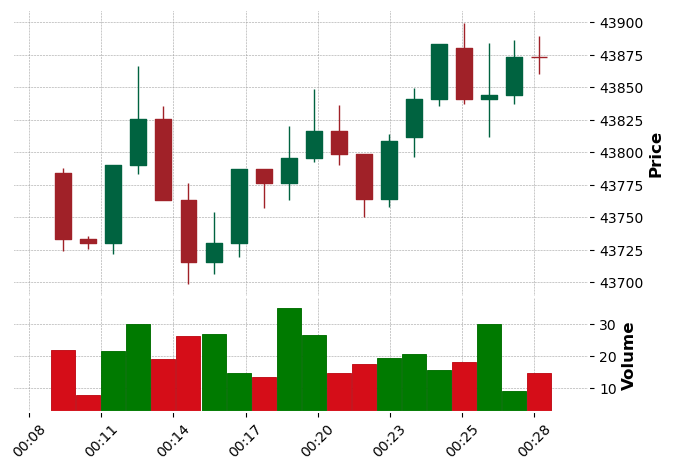

In [ ]:
plot_by_idx(valid_dataset.df, 10, 30)

In [24]:
valid_dataset._get_data(4, True)

,Date,Open,High,Low,Close,Volume,close_date,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
4,2021-10-01 00:04:00,43975.70,44000.75,43940.05,43981.07,106.96885,2021-10-01 00:04:59.999,4.704920e+06,1731,64.88186,2.853647e+06,0
5,2021-10-01 00:05:00,43981.06,44000.37,43960.16,43971.44,41.47681,2021-10-01 00:05:59.999,1.824139e+06,941,13.37400,5.881833e+05,0
6,2021-10-01 00:06:00,43971.41,43971.41,43890.25,43900.00,33.93213,2021-10-01 00:06:59.999,1.490589e+06,1075,17.07979,7.502845e+05,0
7,2021-10-01 00:07:00,43906.77,43922.43,43787.89,43794.24,36.55316,2021-10-01 00:07:59.999,1.603095e+06,1184,9.98706,4.380791e+05,0
8,2021-10-01 00:08:00,43794.24,43806.95,43713.38,43754.97,39.11343,2021-10-01 00:08:59.999,1.711601e+06,1136,15.16637,6.636878e+05,0
9,2021-10-01 00:09:00,43754.97,43792.23,43741.53,43784.10,21.67822,2021-10-01 00:09:59.999,9.486802e+05,722,10.40580,4.553714e+05,0
10,2021-10-01 00:10:00,43784.10,43787.85,43724.27,43733.22,21.78216,2021-10-01 00:10:59.999,9.528046e+05,631,7.29866,3.192394e+05,0
11,2021-10-01 00:11:00,43733.22,43735.87,43725.89,43730.36,7.53373,2021-10-01 00:11:59.999,3.294412e+05,425,4.53768,1.984273e+05,0
12,2021-10-01 00:12:00,43730.36,43790.11,43721.43,43790.10,21.73848,2021-10-01 00:12:59.999,9.508202e+05,529,16.32759,7.141424e+05,0
13,2021-10-01 00:13:00,43790.10,43866.14,43783.11,43825.27,30.07874,2021-10-01 00:13:59.999,1.318280e+06,827,14.86126,6.512282e+05,0
